In [26]:
import json
import os
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.misc
from scipy import ndimage
from sklearn.externals import joblib
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import CustomObjectScope
from skimage.filters import threshold_otsu, threshold_adaptive

In [2]:
def get_models_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for file in files if not file.startswith(".")]
    return files

In [3]:
def get_files_from_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for file in files if not file.startswith(".")]
    return files

In [4]:
models_json = get_models_paths("trained_model_files/symbols/JSON")
print("\n".join("{}: {}".format(*k) for k in enumerate(models_json)))

0: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_98.8_.json
1: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_99.57_.json
2: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_99.61_.json
3: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_99.79_.json
4: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_4EP_99.7_.json
5: trained_model_files/symbols/JSON/TMS_v40_3WAYS_4EP_100.0_.json


In [5]:
models_h5 = get_models_paths("trained_model_files/symbols/H5")
# print("\n".join("{}: {}".format(*k) for k in enumerate(models_h5)))

In [6]:
directories = [x[0] for x in os.walk("/home/apofeo/Documents/symbols")]

In [7]:
# print(directories[1:])
# print(len(directories[1:]))
# print(directories.split("/"))
CATEGORIES = []
for folder in directories[1:]:
    CATEGORIES.append(folder.split("/")[-1])
print(sorted(CATEGORIES))
print(len(CATEGORIES))
CATEGORIES = sorted(CATEGORIES)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'В', 'Е', 'К', 'М', 'Н', 'О', 'Р', 'С', 'Т', 'У', 'Х']
22


In [42]:
def prepare_1ch(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [9]:
def prepare_3ch(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [53]:
index_to_model = 5 # best index is 3 (99.79), worse is 4 (99.7)
json_file = open(models_json[index_to_model], "r")
loaded_model_json = json_file.read()
json_file.close()
# loaded_model = model_from_json(loaded_model_json, custom_objects={'BatchNormalizationV1': BatchNormalizationV1()})
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(models_h5[index_to_model])
loaded_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

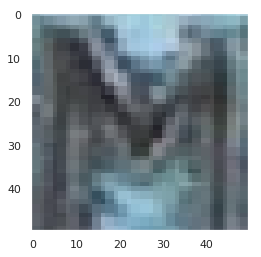

In [54]:
img_path = "/home/apofeo/Documents/detect_result/1_0.png"
# img_path = "/home/apofeo/Documents/clp_rotated_test/train/200/bab717de49084b2a91e3fe2d3f272db3.png"
# img_path = "/home/apofeo/Documents/clp_rotated_v7/test/148/5d98d2923894428d9dd6591d174d926e.png"
# img_path = "im_base_to_angle/rotated_5_pa/test/59/04863e7d13d4462aaaafd675eeaf3170.png"
# img_path = "/home/apofeo/Documents/Screenshot from 2019-03-20 23-39-04.png"
img = image.load_img(img_path, target_size=(50, 50))
img_sobel = ndimage.sobel(img, axis=0, mode='constant')
# img = ndimage.rotate(img, 180, reshape=True)
plt.grid(False)
plt.imshow(img)
# plt.imshow(img_sobel)

In [55]:
prediction = loaded_model.predict(prepare_1ch(img_path))
print(prediction)

[[3.2186073e-11 2.3512580e-13 2.5599224e-08 2.0400238e-04 2.7384502e-08
  2.0855589e-14 3.9770921e-13 2.1245120e-10 6.5512066e-12 9.7838750e-09
  2.2088156e-05 2.2777573e-09 7.1368750e-10 1.7192651e-10 1.5567039e-01
  1.5472736e-11 2.9409639e-10 2.3902044e-16 1.9297754e-11 1.5005083e-06
  8.4410053e-01 1.3700370e-06]]


In [56]:
print(f'{np.argmax(prediction)} ({CATEGORIES[np.argmax(prediction)]})')

20 (У)


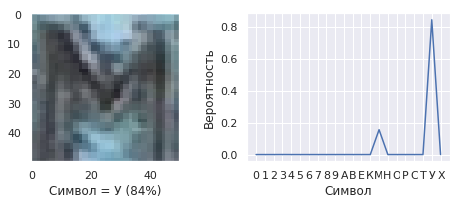

In [57]:
# grid = plt.GridSpec(1, 2, wspace=0.8, hspace=0.3)
# fig, axs = plt.subplots(1,2,figsize=(10,5))
# fig.subplots_adjust(hspace=0.4, wspace=0.5)
fig = plt.figure(figsize=(8, 6))
d = {"Символ": CATEGORIES, "Вероятность": prediction[0]}
pdnumval = pd.DataFrame(d)
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.grid(False)
plt.xlabel(
        "Символ = {} ({:2.0f}%)".format(
            CATEGORIES[np.argmax(prediction)],
            100 * np.max(prediction)
        )
)
plt.subplot(2, 2, 2)
sns.set(style="darkgrid")
sns.lineplot(x="Символ", y="Вероятность", data=pdnumval)

#### Dirty imgs for test

In [172]:
filename = "trained_data/X_4_di_pa_3ch_test.sav"
X = joblib.load(filename)
# print(X[2])
# pickle_in = open("trained_data/X_4_di_pa.pickle","rb")
# X = pickle.load(pickle_in)

In [173]:
filename = "trained_data/y_4_di_pa_3ch_test.sav"
y = joblib.load(filename)
# pickle_in = open("trained_data/y_4_di_pa.pickle","rb")
# y = pickle.load(pickle_in)

In [174]:
filename = "trained_data/Z_4_di_pa_3ch_test.sav"
Z = joblib.load(filename)
# pickle_in = open("trained_data/y_4_di_pa.pickle","rb")
# y = pickle.load(pickle_in)

#### Training set (dirty imgs)

In [61]:
# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(X[i], cmap=plt.cm.binary)
#     plt.xlabel(y[i])
# plt.show()

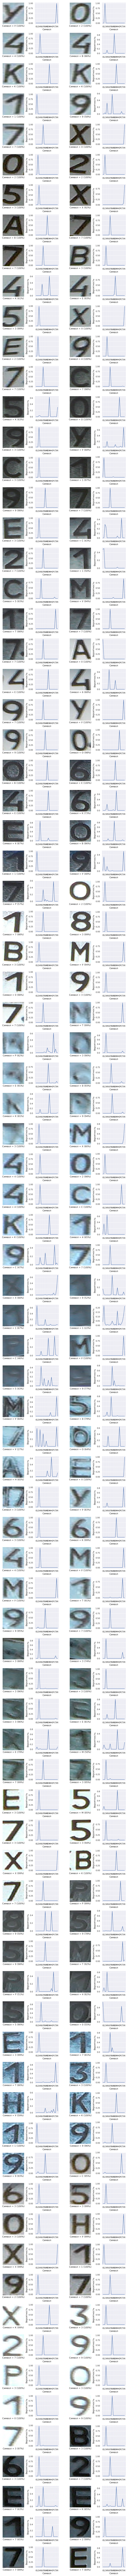

In [58]:
DATADIR = "/home/apofeo/Documents/detect_result"
num_rows = 170
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(6*num_cols, 3*num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, path in enumerate(get_files_from_paths(DATADIR)[:num_images//2]):
    prediction = loaded_model.predict(prepare_1ch(path))
    img = image.load_img(path, target_size=(100, 100))
    d = {"Символ": CATEGORIES, "Вероятность": prediction[0]}
    pdnumval = pd.DataFrame(d)
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(
        "Символ = {} ({:2.0f}%)".format(
            CATEGORIES[np.argmax(prediction)],
            100 * np.max(prediction)
        )
    )
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+2)
    sns.set(style="darkgrid")
    sns.lineplot(x="Символ", y="Вероятность", data=pdnumval)